In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline


failled finding board from:  camera_cal/calibration5.jpg
failled finding board from:  camera_cal/calibration4.jpg
failled finding board from:  camera_cal/calibration1.jpg


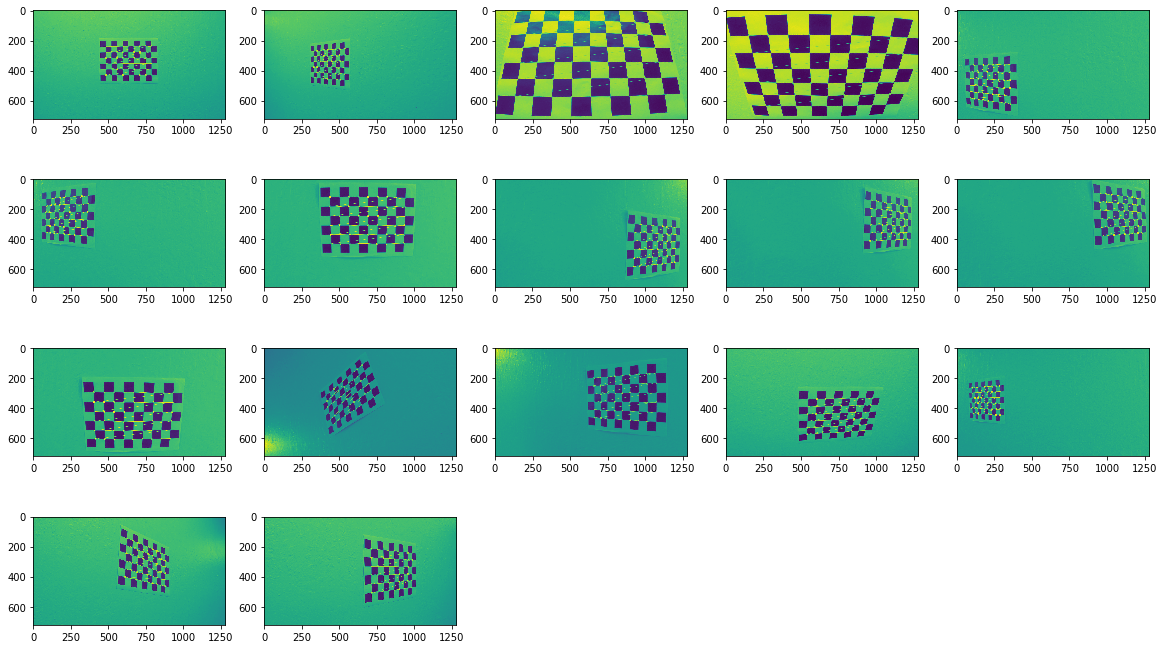

In [41]:
# return 3D coordinates for board corners of given size
def get3DCoor(sizeBoardCorners):
    r, c = sizeBoardCorners
    tar = np.zeros((r*c, 3), np.float32)
    tar[:,:2] = np.mgrid[0:r, 0:c].T.reshape(-1, 2)
    return tar

# find corners of all images from a directory with given corner shape, then caliculate matrix for correcting distortion
def calDistortMatrix(fileDir, sizeBoardCorners):
    calFiles = glob.glob("camera_cal/calibration*.jpg")

    corners_img = []
    corners_tar = []
    
    tarCoord = get3DCoor(sizeBoardCorners)
        
    i = 0
    for fname in calFiles:            
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        if not ret: 
            print('failled finding board from: ', fname)
            continue
        
        corners_img.append(corners)
        corners_tar.append(tarCoord)
            
        # draw the board and the found corners to make sure all are found correctly
        cv2.drawChessboardCorners(gray, sizeBoardCorners, corners, ret)
        plt.subplot(5, 5, i+1)
        plt.imshow(gray)
        i += 1
        
    plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(corners_tar, corners_img, gray.shape, None, None)
    return ret, mtx, dist
    
sizeBoardCorners = (9, 6)
ret, mtx, dist = calDistortMatrix('camera_cal', sizeBoardCorners)


camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration3.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration19.jpg
camera_cal/calibration18.jpg
camera_cal/calibration15.jpg
camera_cal/calibration14.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration13.jpg
camera_cal/calibration12.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration9.jpg
camera_cal/calibration8.jpg
